# Cross-validation and polynomial regression


## Polynomial regression

Polynomial regression consists of fitting some data $(x, y)$ to a $n$-order polynomial of the form:

$$
 y = f(x) = w_0 + w_1 \cdot x + w_2 \cdot x^2 + ... + w_n \cdot x^n
$$
 
By rewriting the unidimensional input $x$ into the following vector:

$$
 \mathbf{x} = \begin{bmatrix} 1 & x & x^2 & ... & x^n \end{bmatrix}
$$

and the weight vector as:

$$
 \mathbf{w} = \begin{bmatrix} w_0 & w_1 & w_2 & ... & w_n \end{bmatrix}
$$
 
the problem can be reduced to linear regression:

$$
 y = \langle \mathbf{w} \cdot \mathbf{x} \rangle
$$
 
 and we can apply the delta learning rule to find $\mathbf{w}$:

$$
 \Delta \mathbf{w} =  \eta \cdot (t_i - y_i ) \cdot \mathbf{x_i}
$$

A first method to perform polynomial regression would be to adapt the code you wrote in the last exercise session for linear classification. However, you saw that properly setting the correct learning rate and stop criteria can be quite tricky. 

The solution retained for this exercise is to use the built-in functions of Numpy which can already perform polynomial regression in an optimized and proved-sure manner (Note: NumPy does not use gradient descent, but rather directly minimizes the error-function by inversing the Gram matrix).

```python
w = np.polyfit(X, t, deg)
```

This function takes the inputs $X$, the desired outputs $t$ and the desired degree of the polynomial `deg`, performs the polynomial regression and returns the adequate set of weights (beware: the higher-order coefficient comes first).

Once the weights are obtained, one can use them to predict the value of an example with the function:

```python
y = np.polyval(w, X)
```

Let's start by importing the usual stuff, define a visualization method and load the data `polynome.data` (16 samples):

In [15]:
import numpy as np
import matplotlib.pyplot as plt
 
def create_dataset():
    
    x = np.linspace(0, 10, 100)
    rng = np.random.default_rng()
    rng.shuffle(x)
    x = np.sort(x[:16])
    t = x * np.sin(x)
    
    return x, t

X, t = create_dataset()

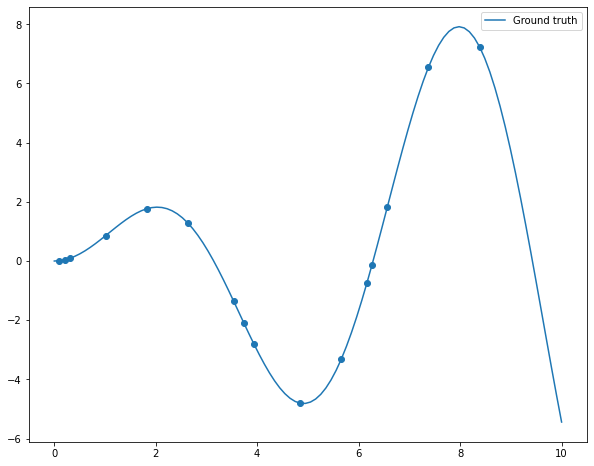

In [16]:
x = np.linspace(0, 10, 100)

plt.figure(figsize=(10, 8))
plt.plot(x, x*np.sin(x), label="Ground truth")
plt.scatter(X, t)
plt.legend()
plt.show()

**Q1:** Apply the `np.polyfit()` function on the data and visualize the result for different degrees of the polynomial (from 1 to 10 or even more). What do you observe? Find a polynomial degree which clearly overfits.

*Bonus question:* make sense of the warning you get when the degree of the polynomial is too high.

/usr/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3417: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


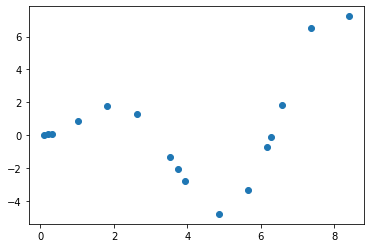

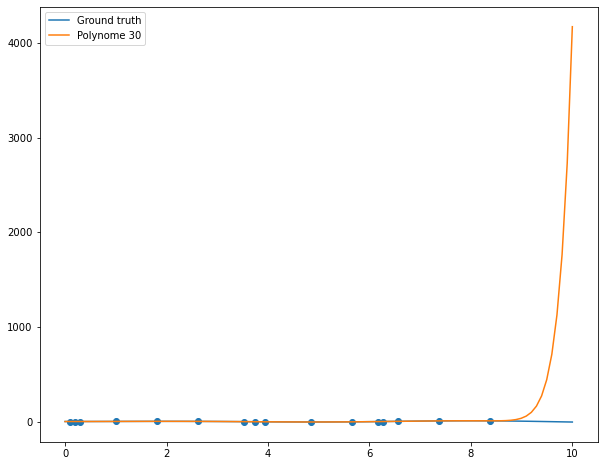

In [24]:
deg = 30

w = np.polyfit(X, t, deg)
y = np.polyval(w, x)

plt.figure()
plt.scatter(X, t)
plt.figure(figsize=(10, 8))
plt.plot(x, x*np.sin(x), label="Ground truth")
plt.plot(x, y, label="Polynome "+str(deg))
plt.scatter(X, t)
plt.legend()
plt.show()

**Q2:** Plot the mean square error on the training set for all polynomial regressions from 1 to 10. How does the training error evolve when the degree of the polynomial is increased? What is the risk by taking the hypothesis with the smallest training error? 

*Hint:* use `np.polyval()` for the prediction, and compute the mse with `np.mean()`.

In [ ]:
training_mse = []
for deg in range(1, 11):
    w = np.polyfit(X, t, deg)
    y = np.polyval(w, X)
    mse = np.mean((t-y)**2)
    training_mse.append(mse)
    print("Degree", deg, ": training error", mse)
    
plt.plot(range(1, 11), training_mse)
plt.xlabel("Order of the polynomial")
plt.ylabel("Training mse")
plt.show()

**Answer:** the more complex the model, the smaller the training error.

## Simple hold-out cross-validation

You will now apply **simple hold-out cross-validation** to find the optimal degree for the polynomial regression. You will need to separate the data set into a training set $S_{\text{train}}$ (70% of the data) and a test set $S_{\text{test}}$ (the remaining 30%). 

The data (X, t) could be easily split into two sets of arrays using slices of indices, as the data is already randomized:

```python
N_train = int(0.7*N)
X_train, t_train = X[:N_train], t[:N_train]
X_test, t_test = X[N_train:], t[N_train:]
```

A much more generic approach is to use the library `scikit-learn` (<https://www.scikit-learn.org>), which provides a method able to split any dataset randomly. 

You can import the method `train_test_split()` from its module:

```python
from sklearn.model_selection import train_test_split
```

The doc of the function is available at: <https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html>.

**Q3:** Use scikit-learn to split the data into the corresponding training and test sets. 

**Q4:** Train each polynomial from degree 1 to 10 on $S_{\text{train}}$ and plot the generalization error on $S_{\text{test}}$. Which degree of the polynomial gives the minimal empirical error? Why?

**Q5:** Run the cross-validation split multiple times. Do you always obtain the same optimal degree? 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, t_train, t_test = train_test_split(X, t, test_size=0.3)

test_mse = []

for deg in range(1, 11):
    w = np.polyfit(X_train, t_train, deg)
    y_test = np.polyval(w, X_test)
    mse = np.mean((t_test-y_test)**2)
    test_mse.append(mse)
    print("Degree", deg, ": empirical error", mse)
    
plt.plot(range(1, 11), test_mse)
plt.xlabel("Order of the polynomial")
plt.ylabel("Test mse")
plt.show()

**Answer:** depending on the split, the optimal degree is either 4, 5, or 6. This is because some samples of the test set might better fit with a given polynomial, depending on how the split was made.  

## k-fold cross-validation

As we only have 16 samples, it is quite annoying to "lose" 5 of them for the test set. Here we can afford to use **k-fold cross-validation**, where the cross-validation split is performed $k$ times:

* The dataset is split into $k$ subsets of equal size (if possible).
* Each subset is iteratively used as the test set, while the $k-1$ other ones are used as a training set.
* The final empirical error is the average of the mse on all subsets.

It would be possible to make the splits using indices too. But it is much easier to use `scikit-learn` once again. You can import the `KFold` class like this:

```python
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits=k, shuffle=True)
```

`n_splits` corresponds to $k$: how many times the dataset is split. Takes $k=4$ for example (4 subsets of 4 samples).

**Q6:** Check the doc of `KFold` (<https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html>). Print the indices of the examples of the training and test sets for each iteration of the algorithm. Change the value of $k$ to understand how it works.

In [ ]:
from sklearn.model_selection import KFold

k = 4
kf = KFold(n_splits=k, shuffle=True)

for train_index, test_index in kf.split(X, t):
    print(train_index)
    print(test_index)

**Q7:** Apply k-fold cross-validation on the polynomial regression problem. Which polynomial degree is the best? Run the split multiple times: does the best polynomial degree change?

**Q8:** Change $k$ to 16. How stable are the results between two runs?

In [ ]:
k = 16
kf = KFold(n_splits=k, shuffle=True)

test_mse = []

for train_index, test_index in kf.split(X, t):
    
    split_mse = []
    for deg in range(1, 11):
        w = np.polyfit(X[train_index], t[train_index], deg)
        y = np.polyval(w, X[test_index])
        mse = np.mean((t[test_index] - y)**2)
        split_mse.append(mse)
    
    test_mse.append(split_mse)
        
test_mse = np.mean(test_mse, axis=0)

print(test_mse)

plt.plot(range(1, 11), test_mse)
plt.xlabel("Degree of the polynome")
plt.ylabel("k-fold cross-validated mse")
plt.show()

**Answer:** a polynomial of order 4 seems the best (it was indeed used to generate the data). With $k=16$ (one sample in the test set every time), the results are the most stable. It is called **leave-one-out cross-validation** (LOOCV). It is the best cross-validation you can make in terms of bias (you use almost all your data to learn), but it is very expensive (you have to retrain your algorithm for each sample) and the empirical error has a high variance.